In [90]:
import os
import seaborn as sns
import pickle as pk
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
#normalizamos

## Features

In [140]:
ruta_regresion= 'CaracteristicasExtraidas\Regression\embbedings\\'

In [141]:
data = os.listdir(ruta_regresion)
data

['vggish_embed_rt_ccas.bunch',
 'vggish_embed_v_A_ccas.bunch',
 'vggish_embed_v_E_ccas.bunch',
 'vggish_embed_v_I_ccas.bunch',
 'vggish_embed_v_O_ccas.bunch',
 'vggish_embed_v_U_ccas.bunch']

In [142]:
bunch_embed_a = pk.load(open(ruta_regresion+'vggish_embed_v_A_ccas.bunch','rb'))

In [260]:
data_emb_a = bunch_embed_a.data
target_emb_a = bunch_embed_a.target.astype(np.int)
updrs = bunch_embed_a.UPDRS.astype(np.int)
upspeech_emb_a = bunch_embed_a.UPDRS_SPEECH.astype(np.int)

data_emb_a_norm = StandardScaler().fit_transform(data_emb_a)
data_emb_a_norm.shape, upspeech_emb_a.shape

((282, 258), (282,))

In [145]:
df = pd.DataFrame(data_trans)
df['target']=upspeech_emb_a.astype(np.int)
df.head()

,0,1,2,3,target
0,-7.119029,-4.116768,1.695013,-0.337000,0
1,-8.193889,-4.085352,4.018889,1.129366,0
2,-7.190875,-2.388500,2.130585,2.072771,0
3,2.768407,1.355009,0.778152,4.963181,0
4,-7.464768,0.462780,-0.634307,1.350085,0


In [146]:
df.dtypes

0         float64
1         float64
2         float64
3         float64
target      int32
dtype: object

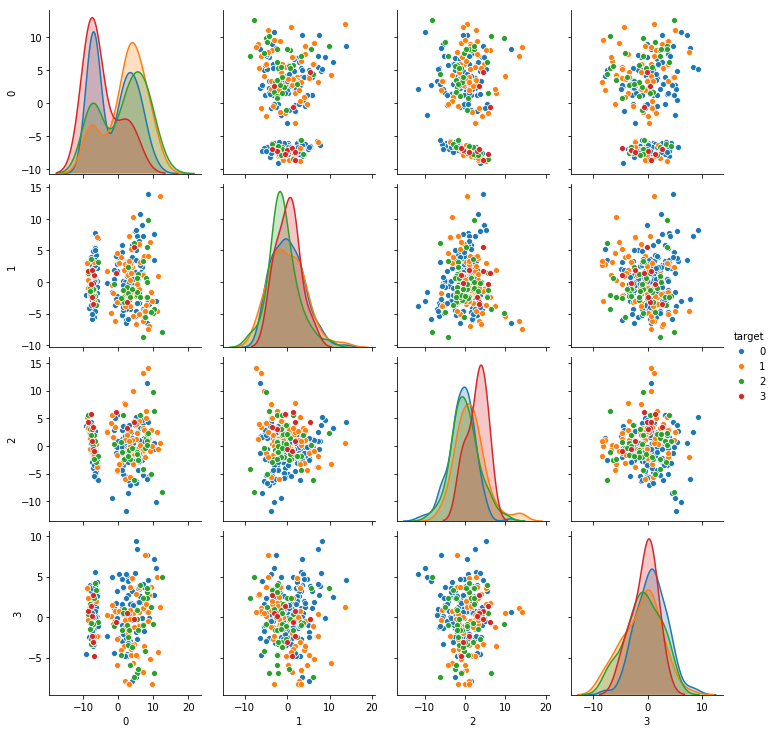

In [147]:
sns.pairplot(df, hue='target');

## Ordinal CLF

In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score


In [256]:
from sklearn.base import clone


class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            y=int(y)
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)
    
    
    
    
    
def CV_not_sklearn(X, y, title=''):
    
    #Guardamos las diferentes medidas
    accuracys = []
    mses = []
    skf = StratifiedKFold(n_splits=10)
    i=0
    for train_index, test_index in skf.split(X, y):
        i+=1
        ################################
        model = OrdinalClassifier(RandomForestClassifier())
        ################################
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #Entrenamos el modelo
        model.fit(X_train, y_train)

        #Testeamos el modelo
        y_pred = model.predict(X_test)
        accuracy  =  accuracy_score(y_test, y_pred)
        mse = np.mean((y_test-y_pred)**2)
        #Guardamos el accuracy y loss devalidación de test
        
        accuracys.append(accuracy)
        mses.append(mse)
        
    return accuracys, mses
    

In [257]:
model = OrdinalClassifier(DecisionTreeClassifier(max_depth=3))
model.fit(data_emb_a, upspeech_emb_a)


In [258]:
model.predict(data_emb_a)

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 2,
       2, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 3, 3, 3, 2, 1, 1, 1, 1, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 3, 3, 0, 1, 0, 0, 2, 2, 1, 1, 1,
       1, 2, 0, 1, 1, 1, 2, 3, 3, 0, 1, 1, 1, 1, 1, 0, 0, 2, 2, 1, 1, 2,
       2, 2, 1, 1, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 0, 2, 2, 2], dtype=int64)

In [262]:
for i, data in enumerate([data_emb_a, data_emb_a_norm, data_trans]):
    for j, labels in enumerate([upspeech_emb_a]):
        print(i, '-', j, end=': ')
        accuracys,mses = CV_not_sklearn(data,labels)
        print(np.mean(accuracys))
        print(np.mean(mses))
        print('----')


0 - 0: 0.5642218573253056
1.0042328042328044
----
1 - 0: 0.5732156540777231
1.0263692756796206
----
2 - 0: 0.5079054916985951
1.1088232074438973
----


## MORD